# MVP Award Prediction Pipeline

## Setup and Data Loading

In [102]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss, classification_report
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Load data
awards_data = pd.read_csv("../../data/initial_data/awards_players.csv")
teams_data = pd.read_csv("../../data/initial_data/teams.csv")
players_teams_clean = pd.read_csv("../awards_data/players_teams_clean.csv")

## Create MVP Data

In [103]:
# Join dataset players_teams_clean data with teams_data
mvp_data = players_teams_clean.merge(
    teams_data[['year', 'tmID', 'won', 'lost', 'rank', 'playoff', 'confID']], 
    left_on=['year', 'team'], 
    right_on=['year', 'tmID'], 
    how='left'
)

# Rename columns
mvp_data.rename(columns={
    'won': 'team_wins', 
    'lost': 'team_losses', 
    'rank': 'conference_rank', 
    'playoff': 'playoff_made'
}, inplace=True)

mvp_data.drop(columns=['tmID'], inplace=True)

# Process categorical columns
mvp_data['playoff_made'] = mvp_data['playoff_made'].map({'Y': 1, 'N': 0})
mvp_data['confID'] = mvp_data['confID'].astype('category').cat.codes

# Add MVP winner field
target_award = 'Most Valuable Player'
mvp_winners = awards_data[awards_data['award'] == target_award][['year', 'playerID']]

mvp_data['MVP_winner'] = mvp_data.apply(
    lambda row: 1 if ((mvp_winners['year'] == row['year']) & 
                      (mvp_winners['playerID'] == row['playerID'])).any() else 0,
    axis=1
)

print(f"Data shape: {mvp_data.shape}")
print(f"MVP winners in dataset: {mvp_data['MVP_winner'].sum()}")

mvp_data.to_csv("mvp_data.csv", index=False)
print("✅ Saved to mvp_data.csv")

Data shape: (1876, 24)
MVP winners in dataset: 10
✅ Saved to mvp_data.csv


## Define Features and Prepare Data

In [104]:
# Define feature columns
feature_columns = [
    'minutes','games_played','total_points','total_rebounds','total_assists',
    'points_per_min','assists_per_min','rebounds_per_min','steals_per_min',
    'blocks_per_min','turnovers_per_min','FG%','FT%','Three%','Three Rate',
    'team_wins','team_losses','conference_rank','playoff_made','confID'
]

# Prepare dataset for training (Year N Stats -> Year N+1 Award)
data = pd.read_csv("mvp_data.csv")

# Create award_year column (The year the award is given, based on prev year stats)
data['award_year'] = data['year'] + 1

# Get winners for the award year
winners = data[data['MVP_winner'] == 1][['year', 'playerID']].copy()

# Merge to create target variable
data = data.merge(
    winners.rename(columns={'year': 'award_year'}),
    on=['award_year', 'playerID'],
    how='left',
    indicator=True
)
data['Target'] = (data['_merge'] == 'both').astype(int)
data.drop(columns=['_merge'], inplace=True)

# Filter candidates
candidates = data[
    (data['minutes'] >= 500) &
    (data['games_played'] >= 20)
].copy()

print(f"Total candidates: {len(candidates)}")
print(f"Positive samples: {candidates['Target'].sum()}")

Total candidates: 866
Positive samples: 7


---
# Section 1: Single-Year Model Testing
Train on Award Years 2-9 (Stats 1-8), Test on Award Year 10 (Stats 9)

## 1.1 Logistic Regression

In [105]:
# Split data using award_year
train_award_years = [2, 3, 4, 5, 6, 7, 8, 9]
test_award_year = 10

train_data = candidates[candidates['award_year'].isin(train_award_years)].copy()
test_data = candidates[candidates['award_year'] == test_award_year].copy()

X_train = train_data[feature_columns]
y_train = train_data['Target']
X_test = test_data[feature_columns]
y_test = test_data['Target']

print(f"Train samples: {len(X_train)} | Test samples: {len(X_test)}")
print(f"Train positives: {y_train.sum()} | Test positives: {y_test.sum()}")

Train samples: 690 | Test samples: 89
Train positives: 6 | Test positives: 1


In [106]:
# Train Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
test_probs = model.predict_proba(X_test_scaled)[:, 1]

print("\n✅ Logistic Regression Model trained!")
print(f"Train accuracy: {accuracy_score(y_train, y_train_pred):.3f}")
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred):.3f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))


✅ Logistic Regression Model trained!
Train accuracy: 0.946
Test accuracy: 0.910

Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        88
           1       0.11      1.00      0.20         1

    accuracy                           0.91        89
   macro avg       0.56      0.95      0.58        89
weighted avg       0.99      0.91      0.94        89



### Feature Importance (Logistic Regression)


Top 10 Most Important Features:
          feature  coefficient
           confID     2.339543
       Three Rate    -1.997370
   blocks_per_min     1.626054
          minutes     1.477143
              FG%    -1.330427
turnovers_per_min    -1.320002
   points_per_min     1.245935
     games_played    -1.094392
    total_assists     1.086160
  conference_rank     1.054944


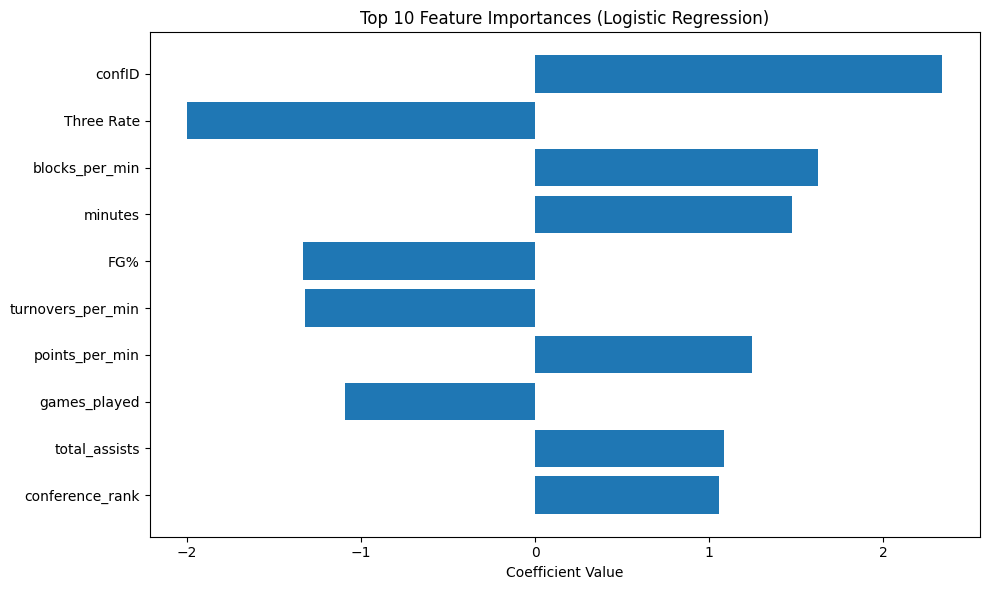

In [107]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'coefficient': model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(top_features['feature'], top_features['coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top 10 Feature Importances (Logistic Regression)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Top Predictions (Logistic Regression)

In [108]:
# Show top predictions
test_data['lr_prob'] = test_probs
test_data_sorted = test_data.sort_values('lr_prob', ascending=False)

print(f"\nYear {test_award_year} MVP Predictions (Logistic Regression):")
print(f"{'Rank':<6}{'Player':<20}{'Team':<6}{'Probability':<12}{'Actual'}")
print("-" * 55)
for idx, (_, row) in enumerate(test_data_sorted.head(10).iterrows(), 1):
    actual = "✅ WINNER" if row['Target'] == 1 else ""
    print(f"{idx:<6}{row['playerID']:<20}{row['team']:<6}{row['lr_prob']:.4f}{'':6}{actual}")


Year 10 MVP Predictions (Logistic Regression):
Rank  Player              Team  Probability Actual
-------------------------------------------------------
1     parkeca01w          LAS   0.9900      
2     tauradi01w          PHO   0.9772      ✅ WINNER
3     leslili01w          LAS   0.9553      
4     anosini01w          MIN   0.9313      
5     augusse01w          MIN   0.9065      
6     jacksla01w          SEA   0.8844      
7     smithta01w          PHO   0.7218      
8     pondeca01w          PHO   0.7061      
9     youngso01w          SAS   0.5281      
10    wiggica01w          MIN   0.2921      


## 1.2 XGBoost

In [109]:
# Train XGBoost
scale_pos_weight = len(y_train[y_train == 0]) / max(len(y_train[y_train == 1]), 1)

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    verbosity=0
)
xgb_model.fit(X_train, y_train)

# Predictions
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)
test_probs_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("\n✅ XGBoost Model trained!")
print(f"Train accuracy: {accuracy_score(y_train, y_train_pred_xgb):.3f}")
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred_xgb):.3f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred_xgb))


✅ XGBoost Model trained!
Train accuracy: 1.000
Test accuracy: 0.989

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        88
           1       0.00      0.00      0.00         1

    accuracy                           0.99        89
   macro avg       0.49      0.50      0.50        89
weighted avg       0.98      0.99      0.98        89



### Feature Importance (XGBoost)


Top 10 Most Important Features (XGBoost):
          feature  importance
     total_points    0.513112
           confID    0.161772
turnovers_per_min    0.090499
   blocks_per_min    0.065699
   steals_per_min    0.033089
       Three Rate    0.027487
  assists_per_min    0.022038
          minutes    0.015825
      team_losses    0.014376
 rebounds_per_min    0.014286


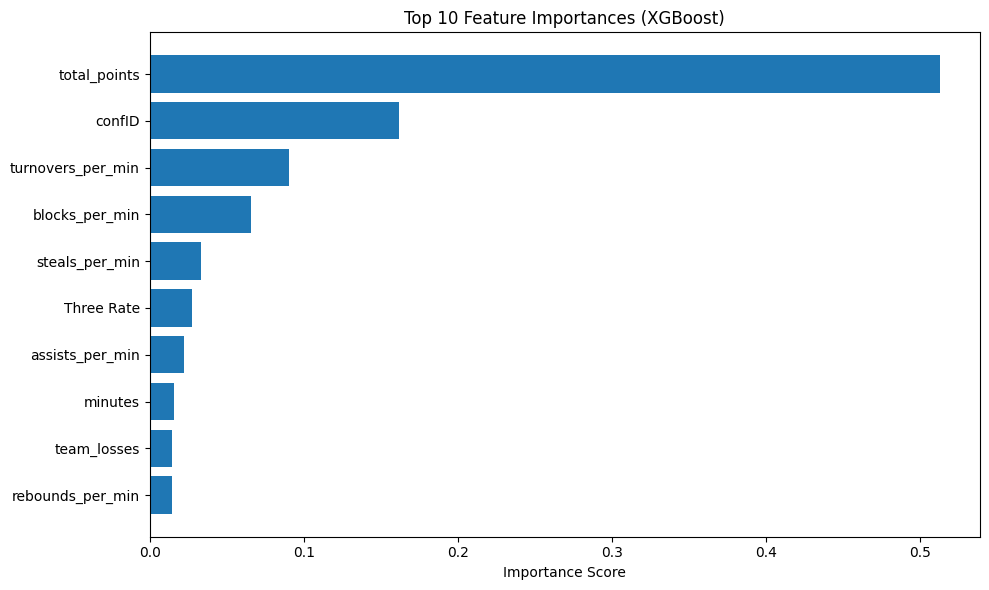

In [110]:
# Get feature importance
feature_importance_xgb = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (XGBoost):")
print(feature_importance_xgb.head(10).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
top_features_xgb = feature_importance_xgb.head(10)
plt.barh(top_features_xgb['feature'], top_features_xgb['importance'])
plt.xlabel('Importance Score')
plt.title('Top 10 Feature Importances (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Top Predictions (XGBoost)

In [111]:
# Show top predictions
test_data['xgb_prob'] = test_probs_xgb
test_data_sorted_xgb = test_data.sort_values('xgb_prob', ascending=False)

print(f"\nYear {test_award_year} MVP Predictions (XGBoost):")
print(f"{'Rank':<6}{'Player':<20}{'Team':<6}{'Probability':<12}{'Actual'}")
print("-" * 55)
for idx, (_, row) in enumerate(test_data_sorted_xgb.head(10).iterrows(), 1):
    actual = "✅ WINNER" if row['Target'] == 1 else ""
    print(f"{idx:<6}{row['playerID']:<20}{row['team']:<6}{row['xgb_prob']:.4f}{'':6}{actual}")


Year 10 MVP Predictions (XGBoost):
Rank  Player              Team  Probability Actual
-------------------------------------------------------
1     youngso01w          SAS   0.4130      
2     leslili01w          LAS   0.0912      
3     parkeca01w          LAS   0.0638      
4     augusse01w          MIN   0.0532      
5     perkiji01w          CHI   0.0092      
6     tauradi01w          PHO   0.0080      ✅ WINNER
7     dupreca01w          CHI   0.0069      
8     wautean01w          SAS   0.0060      
9     thompti01w          HOU   0.0055      
10    nolande01w          DET   0.0050      


---
# Section 2: Multi-Year Evaluation (Leave-One-Out Cross-Validation)
Evaluate models across all available years

In [112]:
# Walk-Forward Cross-Validation Loop (Expand Window)
# Train on years [min_year, ..., T-1], Test on year T

award_years = sorted(candidates['award_year'].unique())
results = []
min_year = min(award_years)

# Start loop from the 3rd available year to have at least 2 years of training data
start_idx = 2 
if start_idx >= len(award_years):
    start_idx = 1 # Fallback

print(f"Running Walk-Forward Cross-Validation...")
print(f"{'Test Year':<10}{'Train Years':<15}{'LR Top1':<10}{'XGB Top1':<10}{'LR Rank':<10}{'XGB Rank':<10}{'Winner'}")
print("-" * 85)

for i in range(start_idx, len(award_years)):
    test_year = award_years[i]
    
    # Walk-Forward Split: Train on ALL years prior to test_year
    train_mask = candidates['award_year'] < test_year
    test_mask = candidates['award_year'] == test_year
    
    train_data_cv = candidates[train_mask].copy()
    test_data_cv = candidates[test_mask].copy()
    
    if len(test_data_cv) == 0 or len(train_data_cv) == 0:
        continue
        
    X_train_cv = train_data_cv[feature_columns]
    y_train_cv = train_data_cv['Target']
    X_test_cv = test_data_cv[feature_columns]
    y_test_cv = test_data_cv['Target']
    
    # --- Logistic Regression ---
    scaler_cv = StandardScaler()
    X_train_scaled_cv = scaler_cv.fit_transform(X_train_cv)
    X_test_scaled_cv = scaler_cv.transform(X_test_cv)
    
    lr_model_cv = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
    lr_model_cv.fit(X_train_scaled_cv, y_train_cv)
    
    lr_prob_cv = lr_model_cv.predict_proba(X_test_scaled_cv)[:, 1]
    
    # --- XGBoost ---
    scale_pos_weight_cv = len(y_train_cv[y_train_cv == 0]) / max(len(y_train_cv[y_train_cv == 1]), 1)
    
    xgb_model_cv = xgb.XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=scale_pos_weight_cv,
        max_depth=6,
        learning_rate=0.1,
        n_estimators=100,
        random_state=42,
        verbosity=0
    )
    xgb_model_cv.fit(X_train_cv, y_train_cv)
    xgb_prob_cv = xgb_model_cv.predict_proba(X_test_cv)[:, 1]

    # --- Random Forest ---
    rf_model_cv = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rf_model_cv.fit(X_train_cv, y_train_cv)
    rf_prob_cv = rf_model_cv.predict_proba(X_test_cv)[:, 1]
    
    # --- Metrics: Top K & Rank ---
    test_data_cv['lr_prob'] = lr_prob_cv
    test_data_cv['xgb_prob'] = xgb_prob_cv
    test_data_cv['rf_prob'] = rf_prob_cv
    
    # Sort by probability
    lr_sorted = test_data_cv.sort_values('lr_prob', ascending=False).reset_index(drop=True)
    xgb_sorted = test_data_cv.sort_values('xgb_prob', ascending=False).reset_index(drop=True)
    rf_sorted = test_data_cv.sort_values('rf_prob', ascending=False).reset_index(drop=True)
    
    actual_winner_row = test_data_cv[test_data_cv['Target'] == 1]
    
    lr_rank = np.nan
    xgb_rank = np.nan
    rf_rank = np.nan
    winner_id = "Unknown"
    
    if len(actual_winner_row) > 0:
        winner_id = actual_winner_row.iloc[0]['playerID']
        
        # Find Rank
        lr_rank_idx = lr_sorted[lr_sorted['playerID'] == winner_id].index
        xgb_rank_idx = xgb_sorted[xgb_sorted['playerID'] == winner_id].index
        rf_rank_idx = rf_sorted[rf_sorted['playerID'] == winner_id].index
        if len(lr_rank_idx) > 0: lr_rank = lr_rank_idx[0] + 1
        if len(xgb_rank_idx) > 0: xgb_rank = xgb_rank_idx[0] + 1
        if len(rf_rank_idx) > 0: rf_rank = rf_rank_idx[0] + 1
    
    # Check Top K
    lr_top1 = 1 if lr_rank == 1 else 0
    lr_top5 = 1 if lr_rank <= 5 else 0
    lr_top10 = 1 if lr_rank <= 10 else 0
    lr_top20 = 1 if lr_rank <= 20 else 0
    lr_top30 = 1 if lr_rank <= 30 else 0
    lr_top50 = 1 if lr_rank <= 50 else 0
    lr_top200 = 1 if lr_rank <= 200 else 0
    
    xgb_top1 = 1 if xgb_rank == 1 else 0
    xgb_top5 = 1 if xgb_rank <= 5 else 0
    xgb_top10 = 1 if xgb_rank <= 10 else 0
    xgb_top20 = 1 if xgb_rank <= 20 else 0
    xgb_top30 = 1 if xgb_rank <= 30 else 0
    xgb_top50 = 1 if xgb_rank <= 50 else 0
    xgb_top200 = 1 if xgb_rank <= 200 else 0

    rf_top1 = 1 if rf_rank == 1 else 0
    rf_top5 = 1 if rf_rank <= 5 else 0
    rf_top10 = 1 if rf_rank <= 10 else 0
    rf_top20 = 1 if rf_rank <= 20 else 0
    rf_top30 = 1 if rf_rank <= 30 else 0
    rf_top50 = 1 if rf_rank <= 50 else 0
    rf_top200 = 1 if rf_rank <= 200 else 0
    
    
    train_years_str = f"{min_year}-{test_year-1}"
    print(f"{test_year:<10}{train_years_str:<15}{lr_top1:<10}{xgb_top1:<10}{lr_rank:<10}{xgb_rank:<10}{winner_id}")
    
    results.append({
        'Test_Year': test_year,
        'LR_Rank': lr_rank,
        'XGB_Rank': xgb_rank,
        'RF_Rank': rf_rank,
        'LR_Top1': lr_top1, 'LR_Top5': lr_top5, 'LR_Top10': lr_top10,
        'LR_Top20': lr_top20, 'LR_Top30': lr_top30, 'LR_Top50': lr_top50, 'LR_Top200': lr_top200,
        'XGB_Top1': xgb_top1, 'XGB_Top5': xgb_top5, 'XGB_Top10': xgb_top10, 'XGB_Top20': xgb_top20,
        'XGB_Top30': xgb_top30, 'XGB_Top50': xgb_top50, 'XGB_Top200': xgb_top200,
        'RF_Top1': rf_top1, 'RF_Top5': rf_top5, 'RF_Top10': rf_top10, 'RF_Top20': rf_top20,
        'RF_Top30': rf_top30, 'RF_Top50': rf_top50, 'RF_Top200': rf_top200
    })


Running Walk-Forward Cross-Validation...
Test Year Train Years    LR Top1   XGB Top1  LR Rank   XGB Rank  Winner
-------------------------------------------------------------------------------------
4         2-3            0         0         11        5         jacksla01w
5         2-4            1         1         1         1         leslili01w
6         2-5            0         0         40        58        swoopsh01w
7         2-6            0         0         15        11        leslili01w
8         2-7            0         0         6         4         jacksla01w
9         2-8            0         0         nan       nan       Unknown
10        2-9            0         0         2         6         tauradi01w
11        2-10           0         0         nan       nan       Unknown


## Summary of Multi-Year Results


===== Walk-Forward Validation Results =====
Metric                       | Logistic Reg | XGBoost      | Random Forest
--------------------------------------------------------------------------------
Top-1 Accuracy               | 12.5%        | 12.5%        | 0.0%
Top-5 Accuracy               | 25.0%        | 37.5%        | 25.0%
Top-10 Accuracy              | 37.5%        | 50.0%        | 62.5%
Top-20 Accuracy              | 62.5%        | 62.5%        | 62.5%
Top-30 Accuracy              | 62.5%        | 62.5%        | 62.5%
Top-50 Accuracy              | 75.0%        | 62.5%        | 75.0%
Top-200 Accuracy             | 75.0%       | 75.0%       | 75.0%
Average Rank                 | 12.5          | 14.2          | 10.3
Rank Std Dev (Consistency)   | 14.5          | 21.7          | 10.7


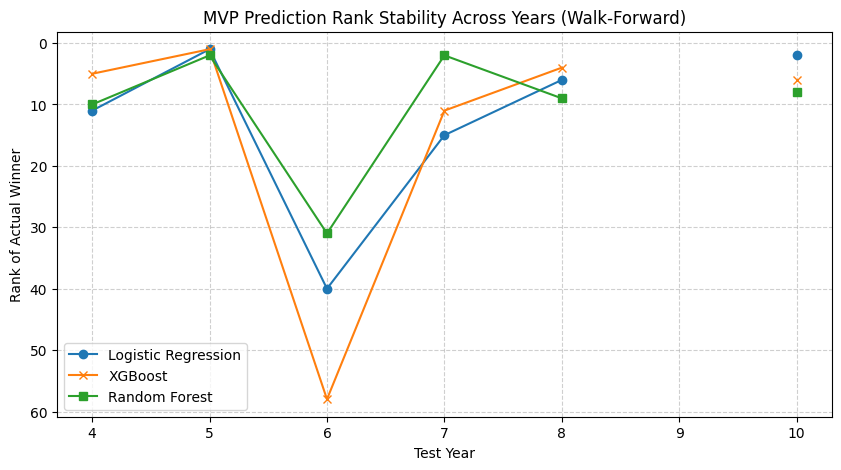

In [113]:
results_df = pd.DataFrame(results)

print("\n===== Walk-Forward Validation Results =====")
print("Metric                       | Logistic Reg | XGBoost      | Random Forest")
print("--------------------------------------------------------------------------------")
print(f"Top-1 Accuracy               | {results_df['LR_Top1'].mean():.1%}        | {results_df['XGB_Top1'].mean():.1%}        | {results_df['RF_Top1'].mean():.1%}")
print(f"Top-5 Accuracy               | {results_df['LR_Top5'].mean():.1%}        | {results_df['XGB_Top5'].mean():.1%}        | {results_df['RF_Top5'].mean():.1%}")
print(f"Top-10 Accuracy              | {results_df['LR_Top10'].mean():.1%}        | {results_df['XGB_Top10'].mean():.1%}        | {results_df['RF_Top10'].mean():.1%}")
print(f"Top-20 Accuracy              | {results_df['LR_Top20'].mean():.1%}        | {results_df['XGB_Top20'].mean():.1%}        | {results_df['RF_Top20'].mean():.1%}")
print(f"Top-30 Accuracy              | {results_df['LR_Top30'].mean():.1%}        | {results_df['XGB_Top30'].mean():.1%}        | {results_df['RF_Top30'].mean():.1%}")
print(f"Top-50 Accuracy              | {results_df['LR_Top50'].mean():.1%}        | {results_df['XGB_Top50'].mean():.1%}        | {results_df['RF_Top50'].mean():.1%}")
print(f"Top-200 Accuracy             | {results_df['LR_Top200'].mean():.1%}       | {results_df['XGB_Top200'].mean():.1%}       | {results_df['RF_Top200'].mean():.1%}")
print(f"Average Rank                 | {results_df['LR_Rank'].mean():.1f}          | {results_df['XGB_Rank'].mean():.1f}          | {results_df['RF_Rank'].mean():.1f}")
print(f"Rank Std Dev (Consistency)   | {results_df['LR_Rank'].std():.1f}          | {results_df['XGB_Rank'].std():.1f}          | {results_df['RF_Rank'].std():.1f}")

# Plot Rank Variation
plt.figure(figsize=(10, 5))
plt.plot(results_df['Test_Year'], results_df['LR_Rank'], marker='o', label='Logistic Regression')
plt.plot(results_df['Test_Year'], results_df['XGB_Rank'], marker='x', label='XGBoost')
plt.plot(results_df['Test_Year'], results_df['RF_Rank'], marker='s', label='Random Forest')
plt.gca().invert_yaxis()  # Rank 1 is at top
plt.title('MVP Prediction Rank Stability Across Years (Walk-Forward)')
plt.ylabel('Rank of Actual Winner')
plt.xlabel('Test Year')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


---
# Section 3: Predict for New Year
Use this section to predict MVP for a future year using past data

## 3.1 Train Final Models on All Available Data

In [114]:
# Train on ALL available data (years 1-10)
all_train_data = candidates[candidates['year'].isin([1,2,3,4,5,6,7,8,9,10])].copy()
X_all = all_train_data[feature_columns]
y_all = all_train_data['Target']

# Train Logistic Regression
scaler_final = StandardScaler()
X_all_scaled = scaler_final.fit_transform(X_all)
model_final = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model_final.fit(X_all_scaled, y_all)

# Train XGBoost
scale_pos_weight_final = len(y_all[y_all == 0]) / max(len(y_all[y_all == 1]), 1)
xgb_model_final = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight_final,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    verbosity=0
)
xgb_model_final.fit(X_all, y_all)

# Train Random Forest
rf_model_final = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model_final.fit(X_all_scaled, y_all)

print("✅ Final models trained on all available data (Years 1-10)")

✅ Final models trained on all available data (Years 1-10)


## 3.2 Load New Year Data and Predict

In [115]:
# Predict MVP for new year using previous year stats
# Example: year_10_players_teams_test.csv -> use year 9 stats -> predict year 10 MVP

# new_year_file = "../../data/yearly_data/year_10_players_teams_test.csv"
new_year_file = "../../data/test_data/players_teams.csv"
predict_year = 11
stats_year = predict_year - 1

print(f"Predicting Year {predict_year} MVP using Year {stats_year} stats")

# Load new year player list
new_year_players = pd.read_csv(new_year_file)
print(f"Players in year {predict_year}: {len(new_year_players)}")

# Get year N-1 stats for these players
player_stats = mvp_data[
    (mvp_data['year'] == stats_year) &
    (mvp_data['playerID'].isin(new_year_players['playerID']))
].copy()

# Filter to candidates
new_candidates = player_stats[
    (player_stats['minutes'] >= 500) &
    (player_stats['games_played'] >= 20)
].copy()

print(f"MVP candidates: {len(new_candidates)}")

Predicting Year 11 MVP using Year 10 stats
Players in year 11: 148
MVP candidates: 67


### Predictions with Logistic Regression

In [116]:
# Predict with Logistic Regression
X_new = new_candidates[feature_columns]
X_new_scaled = scaler_final.transform(X_new)
new_candidates['lr_probability'] = model_final.predict_proba(X_new_scaled)[:, 1]
new_candidates_sorted_lr = new_candidates.sort_values('lr_probability', ascending=False)

print(f"\nYear {predict_year} MVP Predictions (Logistic Regression):")
print(f"{'Rank':<6}{'Player':<25}{'Team':<6}{'Probability':<12}{'PPG':<8}{'Wins'}")
print("-" * 70)
for idx, (_, row) in enumerate(new_candidates_sorted_lr.head(15).iterrows(), 1):
    ppg = row['total_points'] / row['games_played']
    print(f"{idx:<6}{row['playerID']:<25}{row['team']:<6}{row['lr_probability']:.4f}{'':6}{ppg:.1f}{'':6}{int(row['team_wins'])}")

print(f"\n🏆 Predicted MVP (LR): {new_candidates_sorted_lr.iloc[0]['playerID']}")


Year 11 MVP Predictions (Logistic Regression):
Rank  Player                   Team  Probability PPG     Wins
----------------------------------------------------------------------
1     parkeca01w               LAS   0.8150      13.1      18
2     jacksla01w               SEA   0.6827      19.2      20
3     anosini01w               MIN   0.6454      13.2      14
4     youngso01w               SAS   0.5633      18.2      15
5     pondeca01w               PHO   0.3249      19.1      23
6     tauradi01w               PHO   0.2951      20.4      23
7     dupreca01w               CHI   0.1319      15.7      16
8     cashsw01w                SEA   0.0909      12.2      20
9     smithta01w               PHO   0.0529      9.9      23
10    penicti01w               SAC   0.0455      4.9      12
11    powelni01w               SAC   0.0454      16.7      12
12    brunsre01w               SAC   0.0410      12.3      12
13    thompti01w               LAS   0.0308      13.0      18
14    birdsu01w

### Predictions with XGBoost

In [117]:
# Predict with XGBoost
new_candidates['xgb_probability'] = xgb_model_final.predict_proba(X_new)[:, 1]
new_candidates_sorted_xgb = new_candidates.sort_values('xgb_probability', ascending=False)

print(f"\nYear {predict_year} MVP Predictions (XGBoost):")
print(f"{'Rank':<6}{'Player':<25}{'Team':<6}{'Probability':<12}{'PPG':<8}{'Wins'}")
print("-" * 70)
for idx, (_, row) in enumerate(new_candidates_sorted_xgb.head(15).iterrows(), 1):
    ppg = row['total_points'] / row['games_played']
    print(f"{idx:<6}{row['playerID']:<25}{row['team']:<6}{row['xgb_probability']:.4f}{'':6}{ppg:.1f}{'':6}{int(row['team_wins'])}")

print(f"\n🏆 Predicted MVP (XGBoost): {new_candidates_sorted_xgb.iloc[0]['playerID']}")
print()


Year 11 MVP Predictions (XGBoost):
Rank  Player                   Team  Probability PPG     Wins
----------------------------------------------------------------------
1     tauradi01w               PHO   0.0477      20.4      23
2     powelni01w               SAC   0.0297      16.7      12
3     catchta01w               IND   0.0173      15.1      22
4     youngso01w               SAS   0.0081      18.2      15
5     thompti01w               LAS   0.0077      13.0      18
6     houstch01w               MIN   0.0061      13.1      14
7     hammobe01w               SAS   0.0041      19.5      15
8     jacksla01w               SEA   0.0039      19.2      20
9     whaleli01w               CON   0.0036      12.3      16
10    dupreca01w               CHI   0.0034      15.7      16
11    smithta01w               PHO   0.0031      9.9      23
12    wiggica01w               MIN   0.0024      13.1      14
13    pondeca01w               PHO   0.0023      19.1      23
14    douglka01w          

### Predictions with Random Forest

In [118]:
# Predict with Random Forest
new_candidates['rf_probability'] = rf_model_final.predict_proba(X_new_scaled)[:, 1]
new_candidates_sorted_rf = new_candidates.sort_values('rf_probability', ascending=False)

print(f"\nYear {predict_year} MVP Predictions (Random Forest):")
print(f"{'Rank':<6}{'Player':<25}{'Team':<6}{'Probability':<12}{'PPG':<8}{'Wins'}")
print("-" * 70)
for idx, (_, row) in enumerate(new_candidates_sorted_rf.head(15).iterrows(), 1):
    ppg = row['total_points'] / row['games_played']
    print(f"{idx:<6}{row['playerID']:<25}{row['team']:<6}{row['rf_probability']:.4f}{'':6}{ppg:.1f}{'':6}{int(row['team_wins'])}")

print(f"\n🏆 Predicted MVP (RF): {new_candidates_sorted_rf.iloc[0]['playerID']}")



Year 11 MVP Predictions (Random Forest):
Rank  Player                   Team  Probability PPG     Wins
----------------------------------------------------------------------
1     houstch01w               MIN   0.0800      13.1      14
2     jacksla01w               SEA   0.0600      19.2      20
3     tauradi01w               PHO   0.0500      20.4      23
4     parkeca01w               LAS   0.0400      13.1      18
5     thompti01w               LAS   0.0200      13.0      18
6     youngso01w               SAS   0.0200      18.2      15
7     catchta01w               IND   0.0200      15.1      22
8     dupreca01w               CHI   0.0100      15.7      16
9     rileyru01w               SAS   0.0100      5.3      15
10    whaleli01w               CON   0.0100      12.3      16
11    penicti01w               SAC   0.0000      4.9      12
12    quinnno01w               LAS   0.0000      8.4      18
13    mooreje01w               IND   0.0000      4.8      22
14    perkiji01w       